#### Créations des descripteurs de chaque image
1. Pour chaque image passage en gris et equalisation

2. création d'une liste de descripteurs par image ("sift_keyspoints_img") qui sera utilisée pour réaliser les histogrammes par image

3. création d'une liste de descripteurs pour l'ensemble des images ("sift_keyspoints_all_imag") qui sera utilisé pour créer les clusters de descripteurs (on vera çe on détaille  aprés)

In [1]:
from os import getcwd
import pandas as pd
import numpy as np 
import sys
sys.path.append("C:\\Users\\User\\WORK\\workspace-ia\\PERSO\\")
from ara_commons import ara_picture_function as ara_pict
from ara_commons.ara_file import get_dir_files
import matplotlib.pyplot as plt

In [2]:
# ---------------------------------------------------------------------------------------------
#                               MAIN
# ---------------------------------------------------------------------------------------------
verbose = False
force_reloading = True

# Récupère le répertoire du programme
file_path = getcwd() + "\\"
file_path

'c:\\Users\\User\\WORK\\workspace-ia\\simplon\\2022-03-Images\\'

In [3]:
source_data_path = file_path+"dataset\\"
print("Source path :", source_data_path)

Source path : c:\Users\User\WORK\workspace-ia\simplon\2022-03-Images\dataset\


In [4]:
# récupération données
img_extensions = [".jpg", ".jpeg", ".png"]
images = []

for ext in img_extensions:
    images.extend(get_dir_files(source_data_path, endwith=ext))

print(len(images), "images")

400 images


In [5]:
from collections import defaultdict
import re

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 1.Extract keypoints from each image
</div>

In [6]:
img_dic = defaultdict(list)
sift_keyspoints_img=[]
sift_keyspoints_all_img = []

pattern = ara_pict.get_regex_alphabetique_simple()

for img_path in images:
    try:
        img_dic["file_name"].append(img_path)
        name = img_path.lower().split(".")[0]
        name = re.sub(pattern, '', name).strip()
        img_dic["y"].append(name)
        grayimage, keypoint, descriptor = ara_pict.define_img_point(source_data_path+img_path, nb_features=100, display=False, verbose=verbose)
        sift_keyspoints_img.append(descriptor)
        sift_keyspoints_all_img.extend(descriptor)
    except Exception as error:
        print("ERROR : ", img_path)
        print(error)
    

In [7]:
print(len(sift_keyspoints_all_img), len(sift_keyspoints_all_img[0]))

38989 128


In [8]:
df_origin = pd.DataFrame.from_dict(img_dic)
print(df_origin.shape)
df_origin.columns

(400, 2)


Index(['file_name', 'y'], dtype='object')

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 2.Clustering
</div>

We now have an array with a huge number of descriptors. We cannot use all of them to create or model so we need to cluster them. A rule-of-thumb is to create k centers with k = number of categories * 10 (in our case, it's 990).

In [9]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier

In [10]:
species = df_origin["y"].sort_values().unique()
species

array(['cloudy', 'rain', 'shine', 'sunrise'], dtype=object)

In [11]:
# ou sqrt(len(nbrs_descripteurs))
n_clusters=df_origin["y"].sort_values().nunique() * 100
n_clusters

400

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 3.Création des clusters de descripteurs
</div>

* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [12]:
len(sift_keyspoints_all_img)

38989

In [13]:
batch_size = len(images) * 3
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, verbose=verbose).fit(sift_keyspoints_all_img)

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 4.Creation of the histograms
</div>

To create our each image by a histogram. We will create a vector of k value for each image. For each keypoints in an image, we will find the nearest center and increase by one its value.


In [14]:
def predict(img_path, n_clusters, kmeans, model_MLPClassifier=None, nb_features=100, verbose=0):
    _, keypoint, descriptor = ara_pict.define_img_point(img_path, nb_features=nb_features, display=verbose, verbose=verbose)

    histo = np.zeros(n_clusters)
    nkp = np.size(keypoint)

    for d in descriptor:
        idx = kmeans.predict([d])
        histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly
    
    probas = None
    if model_MLPClassifier is not None:
        probas = model_MLPClassifier.predict_proba([histo])

    return probas, histo

In [15]:
histo_list = []

for img_path in images:
    try:
        _, histo = predict(source_data_path+img_path, n_clusters, kmeans, verbose=verbose)
        histo_list.append(histo)
    except Exception as error:
        print("ERROR : ", img_path)
        print(error)

## Training of the neural network

In [16]:
type(species)

numpy.ndarray

In [17]:
X = np.array(histo_list)
Y = []

# It's a way to convert species name into an integer
for s in df_origin["y"].to_list():
    
    Y.append(np.min(np.nonzero(species == s)))

mlp = MLPClassifier(verbose=verbose, max_iter=600000)
mlp.fit(X, Y)

MLPClassifier(max_iter=600000)

In [18]:
mlp.score(X, Y)

1.0

## Predictions

In [32]:
import csv

In [40]:
def pred_df(source_data_path, image_list, n_clusters, kmeans, mlp, species, file_name=None):
    df_test_dict =  defaultdict(list)
    if file_name is not None:
        result_file = open(source_data_path+ file_name, "w")
        result_file_obj = csv.writer(result_file)
        result_file_obj.writerow(np.append("id", species))

    for img_path in image_list:
        try:
            probas, _ = predict(source_data_path+ img_path, n_clusters, kmeans, model_MLPClassifier=mlp)
            proba = probas[0]
            
            if file_name is not None:
                row = []
                row.append(img_path)
                for e in probas[0]:
                    row.append(e)

                result_file_obj.writerow(row)

            name = img_path.lower().split(".")[0]
            name = re.sub(pattern, '', name).strip()
            
            df_test_dict["picture"].append(img_path)
            df_test_dict["target"].append(name)

            max_item = max(proba)
            pre = species[np.where(proba == max_item)][0]
            df_test_dict["predict"].append(pre)
            
            for i in range(0, len(proba)):
                df_test_dict[species[i]+"_proba_"+str(i)].append(round(proba[i],2))  

        except Exception as error:
            print("ERROR : ", img_path)
            print(error)
    return df_test_dict

In [41]:
df_src_dict = pred_df(source_data_path, images, n_clusters, kmeans, mlp, species, file_name="predict_source.csv")

In [42]:
df_src = pd.DataFrame(df_src_dict)
df_src

,picture,target,predict,cloudy_proba_0,rain_proba_1,shine_proba_2,sunrise_proba_3
0,cloudy1.jpg,cloudy,cloudy,0.99,0.00,0.00,0.00
1,cloudy10.jpg,cloudy,cloudy,0.99,0.00,0.00,0.00
2,cloudy100.jpg,cloudy,cloudy,0.97,0.01,0.01,0.00
3,cloudy11.jpg,cloudy,cloudy,0.95,0.03,0.02,0.00
4,cloudy12.jpg,cloudy,cloudy,0.95,0.03,0.01,0.01
...,...,...,...,...,...,...,...
395,sunrise96.jpg,sunrise,sunrise,0.00,0.00,0.00,1.00
396,sunrise97.jpg,sunrise,sunrise,0.00,0.00,0.00,1.00
397,sunrise98.jpg,sunrise,sunrise,0.01,0.00,0.00,0.99
398,sunrise99.jpg,sunrise,sunrise,0.00,0.00,0.00,1.00


In [20]:
result_file = open(source_data_path+ "predict3.csv", "w")
result_file_obj = csv.writer(result_file)
result_file_obj.writerow(np.append("id", species))

df_predict_dict =  defaultdict(list)

for img_path in images:
    try:
        probas, histo = predict(source_data_path+ img_path, n_clusters, kmeans, model_MLPClassifier=mlp)
        row = []
        row.append(img_path)

        for e in probas[0]:
            row.append(e)

        result_file_obj.writerow(row)

    except Exception as error:
        print("ERROR : ", img_path)
        print(error)

result_file.close()

In [24]:
source_data_test_path = source_data_path.replace("dataset", "dataset_test")

# récupération données
images_test = []

for ext in img_extensions:
    images_test.extend(get_dir_files(source_data_test_path, endwith=ext))

print(len(images_test), "images")

62 images


In [25]:
images_test[0:10]

['cloudy002.jpg',
 'cloudy003.jpg',
 'cloudy004.jpg',
 'cloudy005.jpg',
 'cloudy006.jpg',
 'cloudy007.jpg',
 'cloudy008.jpg',
 'cloudy009.jpg',
 'cloudy010.jpg',
 'cloudy011.jpg']

In [ ]:
df_test_dict =  pred_df(source_data_path, images_test, n_clusters, kmeans, mlp, species, file_name="predict_test.csv")
df_test_dict

In [29]:
df_test_dict =  defaultdict(list)

for img_path in images_test:
    try:
        probas, histo = predict(source_data_test_path+ img_path, n_clusters, kmeans, model_MLPClassifier=mlp)
        proba = probas[0]

        name = img_path.lower().split(".")[0]
        name = re.sub(pattern, '', name).strip()
        
        df_test_dict["picture"].append(img_path)
        df_test_dict["target"].append(name)

        max_item = max(proba)
        pre = species[np.where(proba == max_item)][0]
        for i in range(0, len(proba)):
            df_test_dict[i].append(round(proba[i],2))
            df_test_dict[species[i]+"_proba"].append(round(proba[i],2))  

    except Exception as error:
        print("ERROR : ", img_path)
        print(error)

In [30]:
df_test = pd.DataFrame(df_test_dict)
df_test

,picture,target,0,cloudy_proba,1,rain_proba,2,shine_proba,3,sunrise_proba
0,cloudy002.jpg,cloudy,0.90,0.90,0.00,0.00,0.07,0.07,0.03,0.03
1,cloudy003.jpg,cloudy,0.20,0.20,0.03,0.03,0.29,0.29,0.48,0.48
2,cloudy004.jpg,cloudy,0.04,0.04,0.76,0.76,0.20,0.20,0.00,0.00
3,cloudy005.jpg,cloudy,0.91,0.91,0.03,0.03,0.00,0.00,0.06,0.06
4,cloudy006.jpg,cloudy,0.14,0.14,0.52,0.52,0.00,0.00,0.34,0.34
...,...,...,...,...,...,...,...,...,...,...
57,sunrise016.jpg,sunrise,0.00,0.00,0.00,0.00,0.12,0.12,0.88,0.88
58,cloudy001.jpeg,cloudy,0.04,0.04,0.00,0.00,0.64,0.64,0.32,0.32
59,rain002.jpeg,rain,0.00,0.00,0.97,0.97,0.03,0.03,0.00,0.00
60,rain015.jpeg,rain,0.00,0.00,0.14,0.14,0.00,0.00,0.86,0.86


In [93]:
df_test[df_test["target"]!=df_test["predict"]]

,picture,target,predict,cloudy_proba,rain_proba,shine_proba,sunrise_proba
0,cloudy002.jpg,cloudy,shine,0.15,0.01,0.84,0.00
2,cloudy004.jpg,cloudy,rain,0.27,0.71,0.02,0.00
4,cloudy006.jpg,cloudy,rain,0.01,0.97,0.00,0.01
5,cloudy007.jpg,cloudy,shine,0.10,0.10,0.65,0.15
7,cloudy009.jpg,cloudy,sunrise,0.14,0.00,0.00,0.86
9,cloudy011.jpg,cloudy,sunrise,0.02,0.04,0.01,0.92
14,rain001.jpg,rain,sunrise,0.26,0.17,0.03,0.54
20,rain008.jpg,rain,sunrise,0.00,0.00,0.01,0.99
22,rain010.jpg,rain,sunrise,0.00,0.01,0.00,0.99
23,rain011.jpg,rain,sunrise,0.00,0.00,0.00,1.00


In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
import seaborn as sns


In [86]:
df_test.columns

Index(['picture', 'target', 'predict', 'cloudy_proba', 'rain_proba',
       'shine_proba', 'sunrise_proba'],
      dtype='object')

In [88]:
cf_m = confusion_matrix(df_test['target'], df_test['predict'])
cf_m

array([[ 8,  2,  2,  3],
       [ 0, 10,  1,  5],
       [ 7,  1,  2,  5],
       [ 3,  5,  3,  5]], dtype=int64)

In [89]:
df_confusion = pd.DataFrame(cf_m)
df_confusion

,0,1,2,3
0,8,2,2,3
1,0,10,1,5
2,7,1,2,5
3,3,5,3,5


In [90]:
df_confusion["expected"] = ""
for i in range(0, 4):
    df_confusion.loc[i,"expected"] = species[i]
    df_confusion = df_confusion.rename(columns={i:species[i]})

df_confusion

,cloudy,rain,shine,sunrise,expected
0,8,2,2,3,cloudy
1,0,10,1,5,rain
2,7,1,2,5,shine
3,3,5,3,5,sunrise


In [91]:
df_confusion = df_confusion.set_index("expected")
df_confusion

,cloudy,rain,shine,sunrise
expected,,,,
cloudy,8,2,2,3
rain,0,10,1,5
shine,7,1,2,5
sunrise,3,5,3,5


<AxesSubplot:ylabel='expected'>

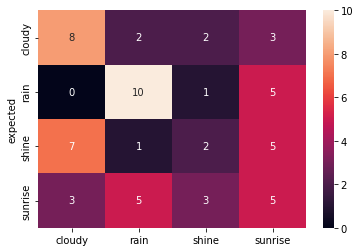

In [92]:
sns.heatmap(df_confusion, annot=True)

<div style="display: flex; background-color: Blue; padding: 15px;" >

## Annexes
</div>

In [ ]:
img_cloudy_path = file_path + "cloudy10.jpg"

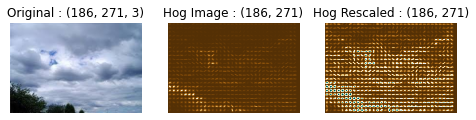

In [ ]:
img_cloudy, resized_img_cloudy, hog_image_cloudy = ara_pict.show_hog(img_path=img_cloudy_path)